In [4]:
import torch
import torch.nn.functional as F

words = open('/code/names.txt').read().splitlines()
print(words[:8])
len(words)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


32033

In [32]:
characters = ['.'] + sorted(list(set(''.join(words)))) 
print(characters)
print(len(characters))
token_mappings = {c:i for i,c in enumerate(characters)}
index_to_character = {i:c for i,c in enumerate(characters)}
print(token_mappings)
print(index_to_character)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [35]:
context_length = 3  # how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = ('.' * context_length) + word + '.'
    for i in range(len(word) - context_length):
        X.append([token_mappings[c] for c in word[i:i+context_length]])
        Y.append(token_mappings[word[i+context_length]])


for x, y in zip(X[:10], Y[:10]):
    print(f"{x} -> {y}")
    print(f"{''.join([index_to_character[i] for i in x])} -> {index_to_character[y]}")
    print('---')

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

[0, 0, 0] -> 5
... -> e
---
[0, 0, 5] -> 13
..e -> m
---
[0, 5, 13] -> 13
.em -> m
---
[5, 13, 13] -> 1
emm -> a
---
[13, 13, 1] -> 0
mma -> .
---
[0, 0, 0] -> 15
... -> o
---
[0, 0, 15] -> 12
..o -> l
---
[0, 15, 12] -> 9
.ol -> i
---
[15, 12, 9] -> 22
oli -> v
---
[12, 9, 22] -> 9
liv -> i
---
torch.Size([228146, 3])
torch.Size([228146])


# Embedding Layer

In [38]:
embedding_dimension = 2
embedding_layer = torch.randn(len(characters), embedding_dimension)
print(embedding_layer.shape)
print(f"Each of the {embedding_layer.shape[0]} characters will have a {embedding_layer.shape[1]}-dimensional embedding")

torch.Size([27, 2])
Each of the 27 characters will have a 2-dimensional embedding


In [55]:
# embedding for g
print(token_mappings['g'])
print(embedding_layer[token_mappings['g']])

_g_one_hot = F.one_hot(torch.tensor(token_mappings['g']), num_classes=len(characters))
print(_g_one_hot)
# matrix multiplication
# all indexes are 0 except for the index of 'g' so these will multiply to 0 and we are left    with
# the embedding for 'g'
print(_g_one_hot.float() @ embedding_layer)
assert (_g_one_hot.float() @ embedding_layer == embedding_layer[token_mappings['g']]).all()

7
tensor([-0.2845, -0.3107])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])
tensor([-0.2845, -0.3107])


In [60]:
# X contains the indexes of the characters in the context
# we can index by X to get the corresponding embeddings for each character in X
print(X[0:2])
print(embedding_layer[X[0:2]])

tensor([[0, 0, 0],
        [0, 0, 5]])
tensor([[[ 0.2764,  0.7453],
         [ 0.2764,  0.7453],
         [ 0.2764,  0.7453]],

        [[ 0.2764,  0.7453],
         [ 0.2764,  0.7453],
         [-0.3747,  0.3328]]])


In [65]:
embeddings = embedding_layer[X]
print(X.shape)
print(f"Our data contains {X.shape[0]} examples with {X.shape[1]} context/characters each.")
print(embeddings.shape)
print(f"Each of the {embeddings.shape[0]} examples will contain {embeddings.shape[1]} context/characters, each having a {embeddings.shape[2]}-dimensional embedding representation.")

torch.Size([228146, 3])
Our data contains 228146 examples with 3 context/characters each.
torch.Size([228146, 3, 2])
Each of the 228146 examples will contain 3 context/characters, each having a 2-dimensional embedding representation.


# Hidden Layer

In [69]:
print(f"We have {context_length} characters in our context and each character has a {embedding_dimension}-dimensional embedding representation.")
num_neurons = 100
W1 = torch.randn(context_length * embedding_dimension, num_neurons)
# b1 (bias) will be added to each row of the result of matrix multiplication of embeddings and W1
b1 = torch.randn(num_neurons)
print(W1.shape)
print(b1.shape)

We have 3 characters in our context and each character has a 2-dimensional embedding representation.
torch.Size([6, 100])
torch.Size([100])


In [78]:
print(torch.arange(0, 18))
print(torch.arange(0, 18).view(3, 6))
print(torch.arange(0, 18).view(3, 3, 2))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


In [87]:
# we want to do something like `embeddings @ W1 + b1`
# but we can't because the dimensions don't match
# we need to reshape the embeddings to be (num_examples, num_inputs)
# so that we can do the matrix multiplication
print(embeddings.shape)
print(embeddings.view(-1, context_length * embedding_dimension).shape)
# print(embeddings)
print(embeddings[2:4])
print(embeddings.view(-1, context_length * embedding_dimension)[2:4])

torch.Size([228146, 3, 2])
torch.Size([228146, 6])
tensor([[[ 0.2764,  0.7453],
         [-0.3747,  0.3328],
         [ 3.0999,  1.0676]],

        [[-0.3747,  0.3328],
         [ 3.0999,  1.0676],
         [ 3.0999,  1.0676]]])
tensor([[ 0.2764,  0.7453, -0.3747,  0.3328,  3.0999,  1.0676],
        [-0.3747,  0.3328,  3.0999,  1.0676,  3.0999,  1.0676]])


In [88]:
# b1 (bias) is added to each row of the result
print(embeddings.view(-1, context_length * embedding_dimension) @ W1 + b1)
print((embeddings.view(-1, context_length * embedding_dimension) @ W1 + b1).shape)
print(num_neurons)

tensor([[-0.2368,  0.4123, -1.3080,  ...,  0.5469, -0.7628, -2.4410],
        [ 0.4879,  0.2590, -0.0377,  ..., -1.0262, -0.6676, -1.5364],
        [-2.3993,  0.0618, -3.2112,  ...,  3.8486, -2.2318, -4.3456],
        ...,
        [-1.0852, -0.5994,  2.2952,  ..., -4.2552, -1.2431,  1.6236],
        [-1.4021,  1.8905,  0.6805,  ..., -1.8729,  1.5798, -1.0906],
        [-0.6784,  1.0732, -2.5214,  ...,  2.8786,  4.5607,  0.6992]])
torch.Size([228146, 100])
100


In [86]:
output_layer = torch.randn(num_neurons, len(characters))
b2 = torch.randn(len(characters))

In [106]:
_fake_X = torch.arange(0, 15).view(-1 , context_length)
print("fake X")
print(_fake_X)
_fake_embeddings_layer = (100 + torch.arange(len(characters) * embedding_dimension)).view(len(characters), embedding_dimension)
print("fake embeddings layer")
print(_fake_embeddings_layer)
_fake_embeddings = _fake_embeddings_layer[_fake_X].view(-1, context_length * embedding_dimension)
print("fake embeddings")
print(_fake_embeddings)
# 10 neurons
_fake_weights = (200 + torch.arange(context_length * embedding_dimension * 10)).view(context_length * embedding_dimension, 10)
print(_fake_weights)
print(_fake_embeddings.shape)
print(_fake_weights.shape)
print((_fake_embeddings @ _fake_weights).shape)
print(_fake_embeddings @ _fake_weights)
print((_fake_embeddings @ _fake_weights)[0][0])
print(_fake_embeddings[0].dot(_fake_weights[:, 0]))
print(_fake_embeddings[0])
print(_fake_weights[:, 0])

fake X
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]])
fake embeddings layer
tensor([[100, 101],
        [102, 103],
        [104, 105],
        [106, 107],
        [108, 109],
        [110, 111],
        [112, 113],
        [114, 115],
        [116, 117],
        [118, 119],
        [120, 121],
        [122, 123],
        [124, 125],
        [126, 127],
        [128, 129],
        [130, 131],
        [132, 133],
        [134, 135],
        [136, 137],
        [138, 139],
        [140, 141],
        [142, 143],
        [144, 145],
        [146, 147],
        [148, 149],
        [150, 151],
        [152, 153]])
fake embeddings
tensor([[100, 101, 102, 103, 104, 105],
        [106, 107, 108, 109, 110, 111],
        [112, 113, 114, 115, 116, 117],
        [118, 119, 120, 121, 122, 123],
        [124, 125, 126, 127, 128, 129]])
tensor([[200, 201, 202, 203, 204, 205, 206, 207, 208, 209],
        [210, 211, 212, 213, 214, 215, 216

In [118]:
logits = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ W1 + b1) @ output_layer + b2
print(logits.shape)
counts = logits.exp()
predicted_probabilities = counts / counts.sum(dim=1, keepdim=True)
print(predicted_probabilities.shape)
# pluck out the probability of the correct character for each example
# if the probability (according to the model) associated with the correct character is low,
# then the loss will be high
# the goal is to minimize the loss, which will result in the model assigning a higher
# probability to the correct character for each example after the weights have been updated
predicted_probabilities_of_actual = predicted_probabilities[torch.arange(len(Y)), Y]
print(predicted_probabilities_of_actual.shape)
loss = -predicted_probabilities_of_actual.log().mean()
print(loss)


torch.Size([228146, 27])
torch.Size([228146, 27])
torch.Size([228146])
tensor(15.7125)


---

# Putting it together

In [138]:
embedding_dimension = 2
context_length = 3
num_neurons = 100

g = torch.Generator().manual_seed(2147483647)
embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)
hidden_layer_weights = torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
hidden_layer_bias = torch.randn(num_neurons, generator=g)
output_layer_weights = torch.randn(num_neurons, len(characters), generator=g)
output_layer_bias = torch.randn(len(characters), generator=g)
parameters = [
    embedding_layer,
    hidden_layer_weights,
    hidden_layer_bias,
    output_layer_weights,
    output_layer_bias
]

In [139]:
print(f"Number of Parameters of Model: {sum(p.nelement() for p in parameters):,}")

Number of Parameters of Model: 3,481


In [140]:
embeddings = embedding_layer[X]
print(embeddings.shape)
h = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
print(h.shape)
logits = h @ output_layer_weights + output_layer_bias
print(logits.shape)
counts = logits.exp()
predicted_probabilities = counts / counts.sum(dim=1, keepdim=True)
print(predicted_probabilities.shape)
predicted_probabilities_of_actual = predicted_probabilities[torch.arange(len(Y)), Y]
print(predicted_probabilities_of_actual.shape)
loss = -predicted_probabilities_of_actual.log().mean()
print(loss)

torch.Size([228146, 3, 2])
torch.Size([228146, 100])
torch.Size([228146, 27])
torch.Size([228146, 27])
torch.Size([228146])
tensor(19.5052)


However, what we did above is equivalent to "cross entropy loss"

- Andrej explains that F.cross_entropy also does some tricks to ensure large values don't cause NaNs: https://youtu.be/TCH_1BHY58I?si=CjVvwzrgzeQCOHr5&t=1976


In [141]:
embeddings = embedding_layer[X]
print(embeddings.shape)
h = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
print(h.shape)
logits = h @ output_layer_weights + output_layer_bias
print(logits.shape)
loss = F.cross_entropy(logits, Y)
print(loss)

torch.Size([228146, 3, 2])


torch.Size([228146, 100])
torch.Size([228146, 27])
tensor(19.5052)


# Training

In [221]:
embedding_dimension = 2
context_length = 3
num_neurons = 100

g = torch.Generator().manual_seed(2147483647)
embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)
hidden_layer_weights = torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
hidden_layer_bias = torch.randn(num_neurons, generator=g)
output_layer_weights = torch.randn(num_neurons, len(characters), generator=g)
output_layer_bias = torch.randn(len(characters), generator=g)
parameters = [
    embedding_layer,
    hidden_layer_weights,
    hidden_layer_bias,
    output_layer_weights,
    output_layer_bias
]
print(f"Number of Parameters of Model: {sum(p.nelement() for p in parameters):,}")

Number of Parameters of Model: 3,481


In [222]:
for p in parameters:
    p.requires_grad = True

In [223]:
# in practice we perform updates on minibatches of data   
losses = []

Loss: 20.616
Loss: 3.814
Loss: 3.161
Loss: 2.711
Loss: 2.710
Loss: 2.293
Loss: 2.495
Loss: 2.656
Loss: 2.741
Loss: 3.012
---
tensor(2.5719, grad_fn=<NllLossBackward0>)


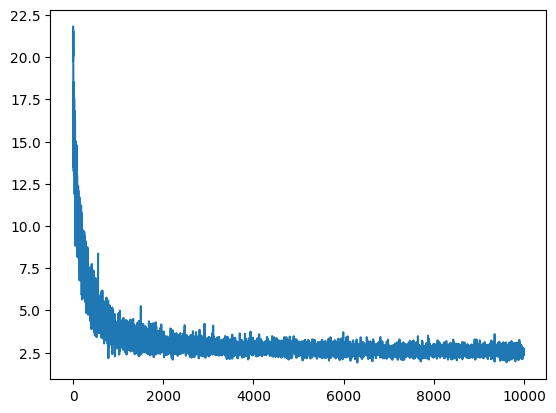

In [224]:
steps = 10000
learning_rate = 0.01
batch_size = 32

for index in range(steps):
    batch_indices = torch.randint(low=0, high=X.shape[0], size=(batch_size,))
    # forward pass
    embeddings = embedding_layer[X[batch_indices]]
    h = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
    logits = h @ output_layer_weights + output_layer_bias
    loss = F.cross_entropy(logits, Y[batch_indices])
    losses.append(loss.item())
    if index % (steps / 10) == 0:
        print(f"Loss: {loss.item():.3f}")
    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

print('---')
# loss on entire training set
embeddings = embedding_layer[X]
h = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
logits = h @ output_layer_weights + output_layer_bias
loss = F.cross_entropy(logits, Y)
print(loss)
# print the loss values
import matplotlib.pyplot as plt
plt.plot(losses)

# Modify to have training / validation / test sets

In [338]:
# import torch

# # Example tensors X and Y
# X = torch.rand(100, 10)  # 100 samples, 10 features each
# Y = torch.rand(100, 1)   # 100 labels

# print(X.size(0))
# # Shuffle the data
# indices = torch.randperm(X.size(0))
# assert len(set(indices)) == X.size(0)
# print(indices)
# X = X[indices]
# Y = Y[indices]

# # Split ratios
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# # Calculate split sizes
# total_size = X.size(0)
# train_size = int(total_size * train_ratio)
# val_size = int(total_size * val_ratio)
# test_size = total_size - train_size - val_size

# # Split the tensors
# X_train, X_val, X_test = torch.split(X, [train_size, val_size, test_size])
# Y_train, Y_val, Y_test = torch.split(Y, [train_size, val_size, test_size])

# # Your training, validation, and test sets are now ready


In [358]:
g = torch.Generator().manual_seed(2147483647)
context_length = 3  # how many characters do we take to predict the next one?

X, Y = [], []

for word in words:
    word = ('.' * context_length) + word + '.'
    for i in range(len(word) - context_length):
        X.append([token_mappings[c] for c in word[i:i+context_length]])
        Y.append(token_mappings[word[i+context_length]])


for x, y in zip(X[:10], Y[:10]):
    print(f"{x} -> {y}")
    print(f"{''.join([index_to_character[i] for i in x])} -> {index_to_character[y]}")
    print('---')

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

# Shuffle the data
indices = torch.randperm(X.size(0), generator=g)
assert len(set(indices)) == X.size(0)
X = X[indices]
Y = Y[indices]

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split sizes
total_size = X.size(0)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the tensors
X_train, X_val, X_test = torch.split(X, [train_size, val_size, test_size])
Y_train, Y_val, Y_test = torch.split(Y, [train_size, val_size, test_size])

# Printing the shapes of the datasets
print("Training set shapes:")
print(X_train.shape)
print(Y_train.shape)
print("Validation set shapes:")
print(X_val.shape)
print(Y_val.shape)
print("Test set shapes:")
print(X_test.shape)
print(Y_test.shape)


[0, 0, 0] -> 5
... -> e
---
[0, 0, 5] -> 13
..e -> m
---
[0, 5, 13] -> 13
.em -> m
---
[5, 13, 13] -> 1
emm -> a
---
[13, 13, 1] -> 0
mma -> .
---
[0, 0, 0] -> 15
... -> o
---
[0, 0, 15] -> 12
..o -> l
---
[0, 15, 12] -> 9
.ol -> i
---
[15, 12, 9] -> 22
oli -> v
---
[12, 9, 22] -> 9
liv -> i
---
torch.Size([228146, 3])
torch.Size([228146])
Training set shapes:
torch.Size([182516, 3])
torch.Size([182516])
Validation set shapes:
torch.Size([22814, 3])
torch.Size([22814])
Test set shapes:
torch.Size([22816, 3])
torch.Size([22816])


In [359]:
embedding_dimension = 10
context_length = 3
num_neurons = 200

embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)
hidden_layer_weights = torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
hidden_layer_bias = torch.randn(num_neurons, generator=g)
output_layer_weights = torch.randn(num_neurons, len(characters), generator=g)
output_layer_bias = torch.randn(len(characters), generator=g)
parameters = [
    embedding_layer,
    hidden_layer_weights,
    hidden_layer_bias,
    output_layer_weights,
    output_layer_bias
]
print(f"Number of Parameters of Model: {sum(p.nelement() for p in parameters):,}")

Number of Parameters of Model: 11,897


torch.Size([27, 10])


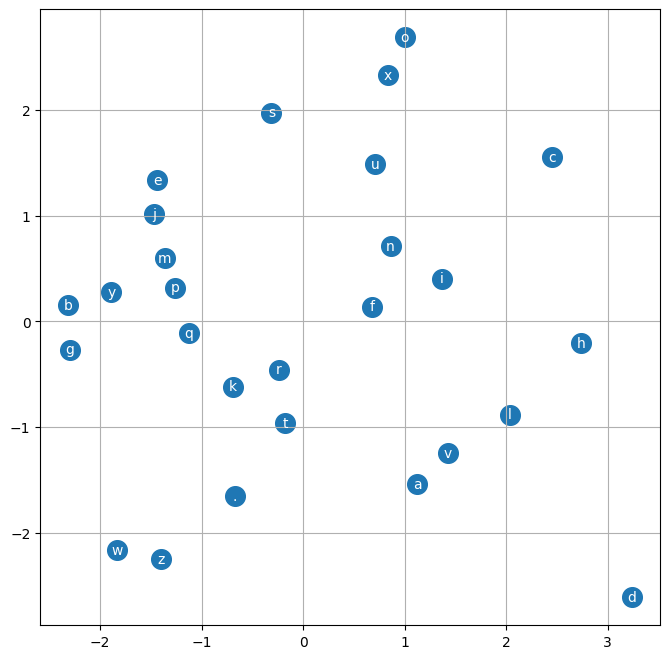

In [360]:
# ONLY VISUALIZING THE FIRST TWO DIMENSIONS OF THE EMBEDDING
# MAY NOT BE THE BEST WAY TO VISUALIZE THE EMBEDDINGS FOR EMBEDDING_DIMENSION > 2
from sklearn.decomposition import PCA
def plot_embeddings():
    embedding_layer_2d = embedding_layer.clone()
    if embedding_layer_2d.shape[1] > 2:
        print("Warning: Embedding dimension greater than 2. Running PCA to extract first two dimensions.")   
        pca = PCA(n_components=2)
        embedding_layer_2d = pca.fit_transform(embedding_layer.detach().numpy())
    # visualize dimensions 0 and 1 of the embedding matrix C for all characters
    from matplotlib import pyplot as plt
    plt.figure(figsize=(8,8))
    plt.scatter(embedding_layer_2d[:,0].data, embedding_layer_2d[:,1].data, s=200)
    for i in range(embedding_layer_2d.shape[0]):
        plt.text(embedding_layer_2d[i,0].item(), embedding_layer_2d[i,1].item(), index_to_character[i], ha="center", va="center", color='white')
    return plt.grid('minor')

print(embedding_layer.shape)

plot_embeddings()

In [361]:
for p in parameters:
    p.requires_grad = True

In [362]:
# in practice we perform updates on minibatches of data   
losses = []

Training Loss (average): 2.173
Training Loss (average): 2.165
Training Loss (average): 2.169
Training Loss (average): 2.169
Training Loss (average): 2.166
Training Loss (average): 2.160
Training Loss (average): 2.169
Training Loss (average): 2.175
Training Loss (average): 2.164
Training Loss (average): 2.150
Training Loss (average): 2.166
Training Loss (average): 2.157
Training Loss (average): 2.152
Training Loss (average): 2.158
Training Loss (average): 2.173
Training Loss (average): 2.159
Training Loss (average): 2.176
Training Loss (average): 2.162
Training Loss (average): 2.171
Training Loss (average): 2.164
---
Validation Loss: 2.192


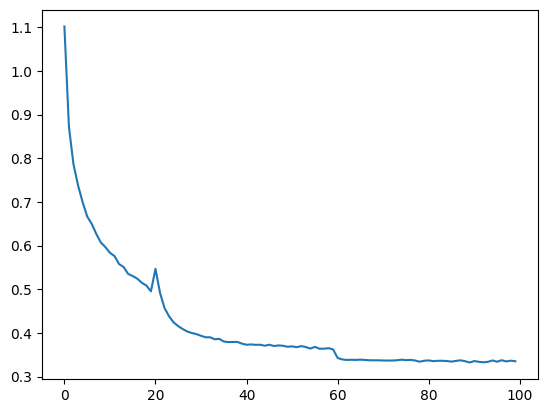

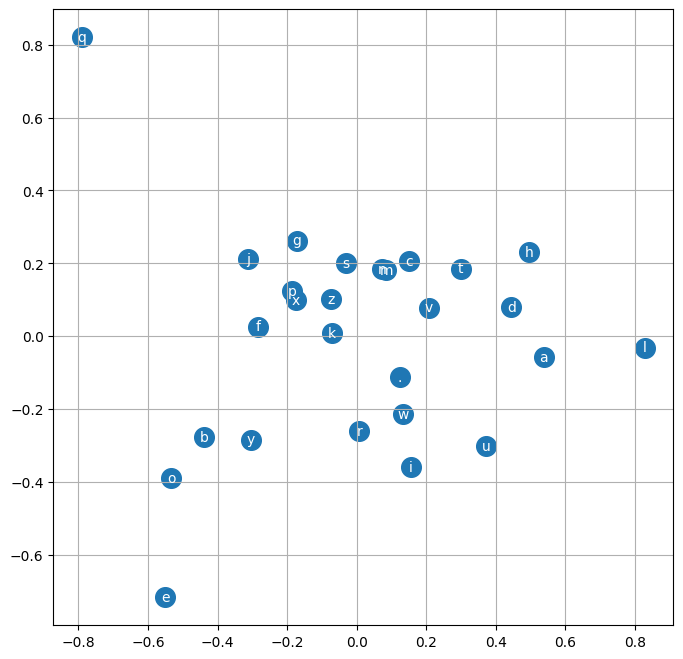

In [370]:
steps = 20000
learning_rate = 0.005
batch_size = 32

sub_losses = []

for index in range(steps):
    batch_indices = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,), generator=g)
    # forward pass
    embeddings = embedding_layer[X_train[batch_indices]]
    h = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
    logits = h @ output_layer_weights + output_layer_bias
    loss = F.cross_entropy(logits, Y_train[batch_indices])
    # losses.append(loss.item())
    sub_losses.append(loss.item())
    if (index + 1) % (steps / 20) == 0:
        average_loss = sum(sub_losses) / len(sub_losses)
        losses.append(average_loss)
        sub_losses = []
        print(f"Training Loss (average): {average_loss:.3f}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

print('---')

# loss on VALIDATION set; the model has not seen this data
embeddings = embedding_layer[X_val]
h = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
logits = h @ output_layer_weights + output_layer_bias
loss = F.cross_entropy(logits, Y_val)
print(f"Validation Loss: {loss:.3f}")
# print the loss values
import matplotlib.pyplot as plt
import math
plt.plot([math.log10(x) for x in losses])
plot_embeddings()

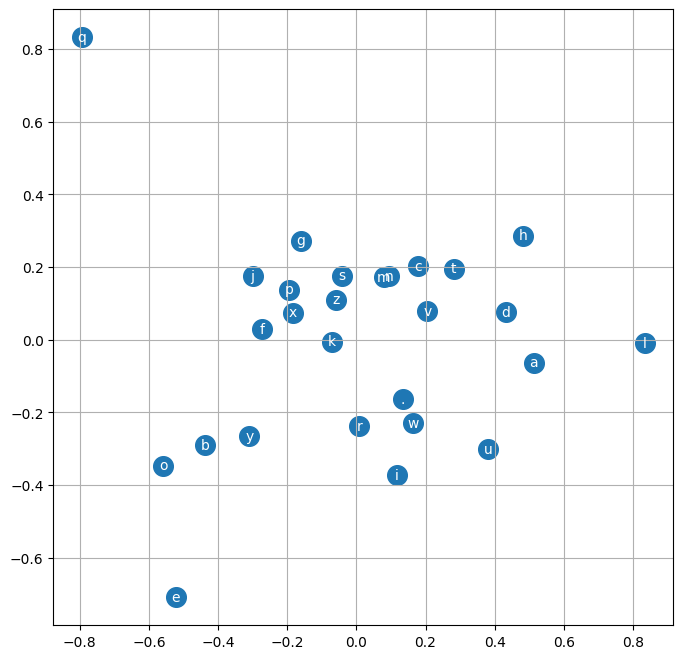

In [369]:
plot_embeddings()

# Generate predictions from the model

In [385]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * context_length # initialize with all ... (which is index 0)
    while True:
      embeddings = embedding_layer[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(embeddings.view(1, -1) @ hidden_layer_weights + hidden_layer_bias)
      logits = h @ output_layer_weights + output_layer_bias
      probs = F.softmax(logits, dim=1)
      # pull random sample from the model's probability distribution
      token_index = torch.multinomial(probs, num_samples=1, generator=None).item()
      context = context[1:] + [token_index]
      out.append(token_index)
      if token_index == 0:
        break
    print(''.join(index_to_character[i] for i in out))

oki.
weanglin.
elian.
one.
leoceoni.
jalee.
avianis.
karhid.
amanno.
giah.
jra.
nit.
ziycaileyishaun.
jod.
beonaliya.
kiddin.
skella.
asgie.
emman.
amanny.


---